# Latam Data Science Challenge 202202

## Resumen

Como resultado del EDA/VDA se tiene:
* El dataset tiene solamente un *missing value* el cual fue ráouda
* A través de los histogramas de diferencia de minutos, se observó que el 80% del total de los vuelos tiene una diferencia menor a los quince minutos establecidos como límite para determinar si hay atraso o no.
* A través de múltiples boxplots de diferencia de minutos vs otras variables, se llegó a visualizar una de las variables más relevante para predecir atraso sobre quince minutos, podría ser la aerolínea, puesto que de las variables revisadas, fue la única que mostró diferencias significativas para el comportamiento de los boxplots.

De la sección de ML se tiene:
* Se ejecutaron 4 modelos de clasificación: Categorical Naive Bayes, Decision Tree Classifier, Random Forest Classifier, Linear Support Vector Classifier.
* El mejor modelo fue el Categorical Naive Bayes con un ***recall_score*** aproximado de 20% y ***accuracy*** estimada de 80%.

### Mejor aún
Entre otras mejoras, hubiera sido ideal contar datos adicionales que permitieran caracterizar los vuelos, tales como:
* Datos de clima al momento de programar el vuelo (Cli-I) y datos de clima al momento de operar el vuelo (Cli-O)
* Identificación del vuelo anterior que utilice la misma puerta de embarque (también programado y operado)
* Otras distinciones de temporalidad que ayuden a reducir la variedad de fechas, aparte de temporada_alta, tales como estaciones por hemisferio (ej: Ver-Sur que sería verano en el hemisferio sur, o Inv-Nor que sería invierno en el hemisferio norte).

### Más Mejor aún
En el entendido que la meta es mejorar el desempeño de los vuelos de Latam (superadas las externalidades que puedan provenir de los vuelos de otras aerolíneas), sería clave contar con información detallada de sus propios vuelos:
* Datos de avión: modelo, capacidades nominales (pasajeros, carga, combustible), años de servicio, historial de fallas, etc.
* Datos de vuelo
    * Datos de tripulación: capitán, copiloto, jefe/jefa de servicio.
    * Datos de pasajeros: total de asientos vendidos, cantidades de pasajeros en interconexión, cantidad prevista de niños, historial de vuelos perdidos previos de los pasajeros.
    * Datos de aeropuerto: puerta asignada, pista de despegue asignada, condición climática.

In [1]:
# Setting up configs
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [117]:
# First batch of imports for EDA/VDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.style.use("seaborn")
import seaborn as sns
sns.set_style("darkgrid")

# Classifiers
from sklearn.naive_bayes import CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# Other ML tools
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score

%load_ext watermark
%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2022-03-13T19:25:44.264532-03:00

Python implementation: CPython
Python version       : 3.7.11
IPython version      : 7.12.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 4
Architecture: 64bit



In [3]:
# Setting pandas displaying options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Exploratory Data Analysis

**tl;dr: sección de revisión de dataset y creación de variables sintéticas solicitadas. El dataset principalmente contiene variables de tipo etiquetas.**

En esta sección se cubren los requerimientos referidos a creación de variables sintéticas depdendientes de las provistas en el dataset original.

Además, se cubren las evaluaciones básicas de datos faltantes (y gestión de los mismos), y asignación de tipos de datos cuando corresponda.

Dado que no solamente se cuenta con variables de tipo etiquetas tales como ciudades (ida - destino, aerolíneas, Vlo-I, Vlo-O, etc.) sino que además se generan otras variables de tipo etiquetas (incluso el atraso termina siendo tratado en forma binaria), se presume que en la sección de ML se deberán evaluar modelos de clasificación.

In [4]:
#Importing data and checking basics
data_SCL = pd.read_csv("data/dataset_SCL.csv")

print(f"{data_SCL.head()}\n")
print(f"{data_SCL.tail()}\n")
print(f"{data_SCL.info()}\n")

               Fecha-I Vlo-I Ori-I Des-I Emp-I              Fecha-O Vlo-O Ori-O Des-O Emp-O  DIA  MES   AÑO     DIANOM TIPOVUELO              OPERA  SIGLAORI SIGLADES
0  2017-01-01 23:30:00   226  SCEL  KMIA   AAL  2017-01-01 23:33:00   226  SCEL  KMIA   AAL    1    1  2017    Domingo         I  American Airlines  Santiago    Miami
1  2017-01-02 23:30:00   226  SCEL  KMIA   AAL  2017-01-02 23:39:00   226  SCEL  KMIA   AAL    2    1  2017      Lunes         I  American Airlines  Santiago    Miami
2  2017-01-03 23:30:00   226  SCEL  KMIA   AAL  2017-01-03 23:39:00   226  SCEL  KMIA   AAL    3    1  2017     Martes         I  American Airlines  Santiago    Miami
3  2017-01-04 23:30:00   226  SCEL  KMIA   AAL  2017-01-04 23:33:00   226  SCEL  KMIA   AAL    4    1  2017  Miercoles         I  American Airlines  Santiago    Miami
4  2017-01-05 23:30:00   226  SCEL  KMIA   AAL  2017-01-05 23:28:00   226  SCEL  KMIA   AAL    5    1  2017     Jueves         I  American Airlines  Santiago    Miam

C:\Users\pablo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# Quick check para revisar relación para revisar relación ciudades a aeropuertos
print(data_SCL.groupby(["SIGLADES", "Des-I"])["OPERA"].count())

SIGLADES          Des-I
Antofagasta       SCFA     5786
Arica             SCAR     2436
Asuncion          SGAS      232
Atlanta           KATL      358
Auckland N.Z.     NZAA      361
Balmaceda         SCBA      839
Bariloche         SAZS        2
Bogota            SKBO     1604
Buenos Aires      SABE     3094
                  SAEZ     3240
                  SEGU        1
Calama            SCCF     5145
                  SCFA        1
Cancun            MMUN       63
Castro (Chiloe)   SCPQ      235
Cataratas Iguacu  SARI        1
                  SBFI        1
Ciudad de Mexico  MMMX      700
Ciudad de Panama  MPTO     1850
Cochabamba        SLCB        1
Concepcion        SCIE     3993
Copiapo           SCAT     1780
Cordoba           SACO     1023
Curitiba, Bra.    SBCT        3
Dallas            KDFW      357
Florianapolis     SBFL      162
Guayaquil         SEGU      422
Houston           KIAH      334
Iquique           SCDA     3747
Isla de Pascua    SCIP      452
La Paz          

Se observa que existen ciudades con más de un aeropuerto. Esto pudiera ser relevante, pues pudiera hallarse que hallan aeropuertos de destino en específico que generen atrasos en los vuelos.

In [6]:
# Checking row of missing value
print(data_SCL[data_SCL["Vlo-O"].isnull()])

# Filling missing value
"""Se determina completar el campo faltante con el valor de Vlo-I porque
los valores entre Vlo-O y Vlo-I se corresponden, según lo visto en los métodos
head() y tail()"""
data_SCL['Vlo-O'].fillna(data_SCL["Vlo-I"], inplace=True)

print(f"\n{data_SCL.iloc[6068]}\n")

                  Fecha-I Vlo-I Ori-I Des-I Emp-I              Fecha-O Vlo-O Ori-O Des-O Emp-O  DIA  MES   AÑO  DIANOM TIPOVUELO                 OPERA  SIGLAORI SIGLADES
6068  2017-01-19 11:00:00   200  SCEL  SPJC   LAW  2017-01-19 11:03:00   NaN  SCEL  SPJC   56R   19    1  2017  Jueves         I  Latin American Wings  Santiago     Lima

Fecha-I       2017-01-19 11:00:00
Vlo-I                         200
Ori-I                        SCEL
Des-I                        SPJC
Emp-I                         LAW
Fecha-O       2017-01-19 11:03:00
Vlo-O                         200
Ori-O                        SCEL
Des-O                        SPJC
Emp-O                         56R
DIA                            19
MES                             1
AÑO                          2017
DIANOM                     Jueves
TIPOVUELO                       I
OPERA        Latin American Wings
SIGLAORI                 Santiago
SIGLADES                     Lima
Name: 6068, dtype: object



In [7]:
# Parsing dates
data_SCL["Fecha-I"] = pd.to_datetime(data_SCL["Fecha-I"],
                                     format = "%Y-%m-%d %H:%M:%S")
data_SCL["Fecha-O"] = pd.to_datetime(data_SCL["Fecha-O"],
                                     format = "%Y-%m-%d %H:%M:%S")

In [8]:
# Setting temporada_alta
"""Lo hice por fuerza bruta, en tanto encuentre una forma pitónica de modificar las fechas
acorde al esquema provisto"""

data_SCL["temporada_alta"] = 0

data_SCL.loc[((data_SCL["Fecha-I"].dt.month == 12) & \
              (data_SCL["Fecha-I"].dt.day >= 15) \
            | (data_SCL["Fecha-I"].dt.month <= 2) 
            | (data_SCL["Fecha-I"].dt.month == 3) & \
            (data_SCL["Fecha-I"].dt.day <= 3)), "temporada_alta"] = 1

data_SCL.loc[((data_SCL["Fecha-I"].dt.month == 7) & \
              (data_SCL["Fecha-I"].dt.day >= 15)), "temporada_alta"] = 1

data_SCL.loc[((data_SCL["Fecha-I"].dt.month == 9) & \
              (data_SCL["Fecha-I"].dt.day >= 11)), "temporada_alta"] = 1

data_SCL["temporada_alta"] = data_SCL["temporada_alta"].astype("bool")

In [9]:
# Creating dif_min column
data_SCL["dif_min"] = (data_SCL["Fecha-O"] - \
                       data_SCL["Fecha-I"]).astype("timedelta64[m]")

data_SCL["dif_min"] = data_SCL["dif_min"].astype("int")

In [10]:
# Creating atraso_15 column
data_SCL["atraso_15"] = 0
data_SCL.loc[(data_SCL["dif_min"] > 15), "atraso_15"] = 1
data_SCL["atraso_15"] = data_SCL["atraso_15"].astype("bool")

In [11]:
# Creating periodo_dia column
data_SCL.loc[((data_SCL["Fecha-I"].dt.hour >= 5) &
              (data_SCL["Fecha-I"].dt.hour < 12)), "periodo_dia"] = "mañana"
data_SCL.loc[((data_SCL["Fecha-I"].dt.hour >= 12) &
              (data_SCL["Fecha-I"].dt.hour < 19)), "periodo_dia"] = "tarde"
data_SCL.loc[((data_SCL["Fecha-I"].dt.hour >= 19) |
              (data_SCL["Fecha-I"].dt.hour < 5)), "periodo_dia"] = "noche"

data_SCL["periodo_dia"] = data_SCL["periodo_dia"].astype("category")
data_SCL[["Fecha-I", "periodo_dia"]].dtypes

print(f"\n{data_SCL.head()}\n{data_SCL.info()}\n")
print(f"{data_SCL.describe()}\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Fecha-I         68206 non-null  datetime64[ns]
 1   Vlo-I           68206 non-null  object        
 2   Ori-I           68206 non-null  object        
 3   Des-I           68206 non-null  object        
 4   Emp-I           68206 non-null  object        
 5   Fecha-O         68206 non-null  datetime64[ns]
 6   Vlo-O           68206 non-null  object        
 7   Ori-O           68206 non-null  object        
 8   Des-O           68206 non-null  object        
 9   Emp-O           68206 non-null  object        
 10  DIA             68206 non-null  int64         
 11  MES             68206 non-null  int64         
 12  AÑO             68206 non-null  int64         
 13  DIANOM          68206 non-null  object        
 14  TIPOVUELO       68206 non-null  object        
 15  OP

## Visual Data Analysis

tl;dr: aproximadamente un 80% de los vuelos, no presenta atraso por sobre los quince minutos. Las visualizaciones presentadas conducen a pensar que una de la variables con más peso para estimar atraso por sobre 15 minutos, es la aerolínea. Otras variables como día de la semana, temporada alta, o tipo de vuelo, no evidencian ser relevantes.

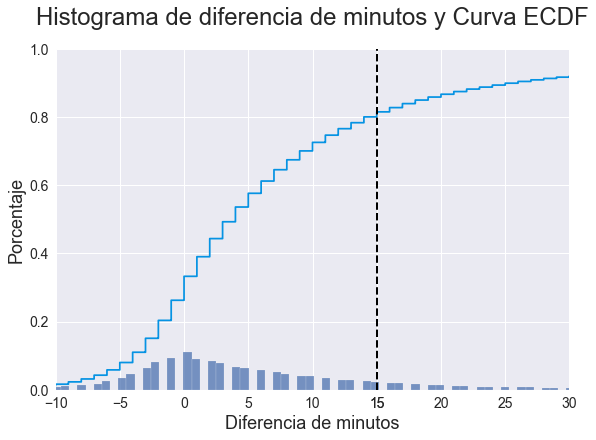

In [12]:
# min_dif histogram
fig, ax = plt.subplots(constrained_layout=True, figsize=(8,6))

sns.histplot(data=data_SCL, x="dif_min", stat="density", ax=ax)
sns.ecdfplot(data=data_SCL, x="dif_min", stat="proportion", color="#0693e3",
             ax=ax)
ax.set_xlim(-10, 30)
ax.set_xticks(list(plt.xticks()[0]) + [15])
ax.axvline(x=15, linestyle="--", linewidth="2", color="black")
ax.set_xlabel("Diferencia de minutos", size=18)
ax.set_ylabel("Porcentaje", size=18)
ax.tick_params(axis="both", which="major", labelsize=14)

plt.title("Histograma de diferencia de minutos y Curva ECDF", size=24, pad=24)
plt.savefig("graphs/HIST_dif_min03.png", bbox_inches="tight")

El histograma de diferencia de minutos y curva ECDF nos muestra que el 80% del total de vuelos tiene un valor de diferencia de minutos igual o menor a quince minutos, incluidos aquellos vuelos que incluso salen antes de tiempo.

En el peor caso, de no contar con más herramientas para revisar el comportamiento de los vuelos , se podrían tomar los datos actuales y mediante distribución beta, inferir la cual sea el valor más probable de la probabilidad con que los vuelos se retrasan.

El siguiente paso es empezar a distinguir el atraso entre las distintas categorías de las que se dispone.

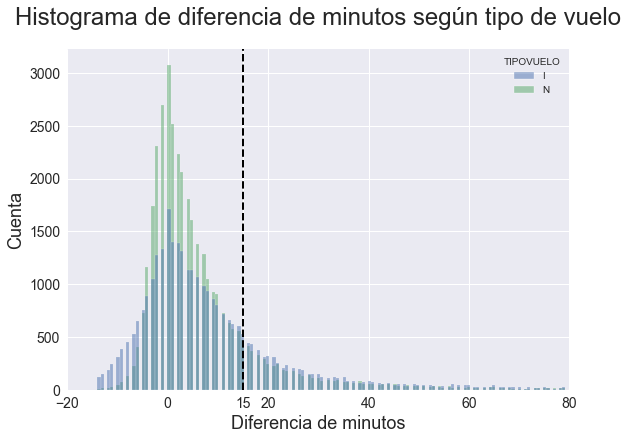

In [13]:
# min_dif histogram by TIPOVUELO
fig, ax = plt.subplots(constrained_layout=True, figsize=(8,6))

sns.histplot(data=data_SCL, x="dif_min", hue="TIPOVUELO", ax=ax)
ax.set_xlim(-20, 80)
ax.set_xticks(list(plt.xticks()[0]) + [15])
ax.axvline(x=15, linestyle="--", linewidth="2", color="black")
ax.set_xlabel("Diferencia de minutos", size=18)
ax.set_ylabel("Cuenta", size=18)
ax.tick_params(axis="both", which="major", labelsize=14)

plt.title("Histograma de diferencia de minutos según tipo de vuelo",
          size=24, pad=24)
plt.savefig("graphs/HIST_dif_min02.png", bbox_inches="tight")

A partir del revisión del histograma de diferencia de minutos, separada por Tipo de vuelo (nacional vs internacional), se puede observar que los comportamientos siguen las mismas tendencias observadas en el punto anterior: que el 80% de los vuelos, tanto nacionales como internacionales, está dentro del tiempo que califica como "no atraso". Este histograma muestra además como los vuelos nacionales superan en cantidad a los vuelos internacionales.

Intuitivamente, se esperaba encontrar que los vuelos internacionales tuvieran mayores niveles de atraso, dado los mayores niveles de logística requerida.

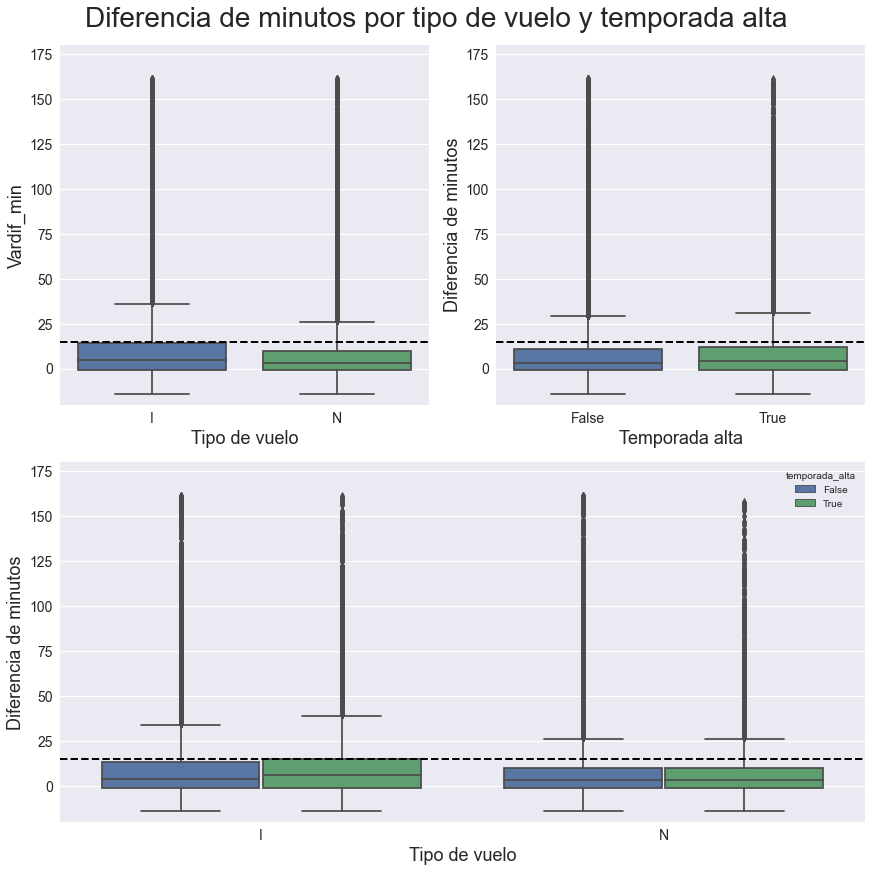

In [14]:
fig = plt.figure(constrained_layout=True, figsize=(12,12))

gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

# dif_min boxplot by TIPOVUELO
sns.boxplot(data=data_SCL, x="TIPOVUELO", y="dif_min", ax=ax1)
ax1.set_xlabel("Tipo de vuelo", size=18)
ax1.set_ylim(-20, 180)
ax1.set_ylabel("Vardif_min", size=18)
ax1.axhline(y=15, linestyle="--", linewidth="2", color="black")
ax1.tick_params(axis="both", which="major", labelsize=14)

# dif_min boxplot by temporada_alta,
sns.boxplot(data=data_SCL, x="temporada_alta", y="dif_min", ax=ax2)
ax2.set_xlabel("Temporada alta", size=18)
ax2.set_ylabel("Diferencia de minutos", size=18)
ax2.set_ylim(-20, 180)
ax2.axhline(y=15, linestyle="--", linewidth="2", color="black")
ax2.tick_params(axis="both", which="major", labelsize=14)

# dif_min boxplot by TIPOVUELO, hue by temporada_alta
sns.boxplot(data=data_SCL, x="TIPOVUELO", y="dif_min", hue="temporada_alta",
            ax=ax3)
ax3.set_xlabel("Tipo de vuelo", size=18)
ax3.set_ylabel("Diferencia de minutos", size=18)
ax3.set_ylim(-20, 180)
ax3.axhline(y=15, linestyle="--", linewidth="2", color="black")
ax3.tick_params(axis="both", which="major", labelsize=14)

fig.suptitle("Diferencia de minutos por tipo de vuelo y temporada alta",
             size=28)
plt.savefig("graphs/BXPLT_dif_min01.png", bbox_inches="tight")

Los boxplots presentados, vienen a tratar de revelar la distribución de diferencia de minutos de los vuelos, respecto de:
* Tipo de vuelo
* Temporada alta
* Tipo de vuelo & Temporada alta

En todos los casos, se puede observar que las líneas de corte que representan los 15 minutos, quedan por sobre el borde superior de las cajas, que representan el percentil 75 de los datos. Esto indica que se deben seguir buscando variables que permitan discriminar en forma efectiva, cuales pudieran ser factores diferencia de minutos mayor a quince (valor 1/True de atraso_15).


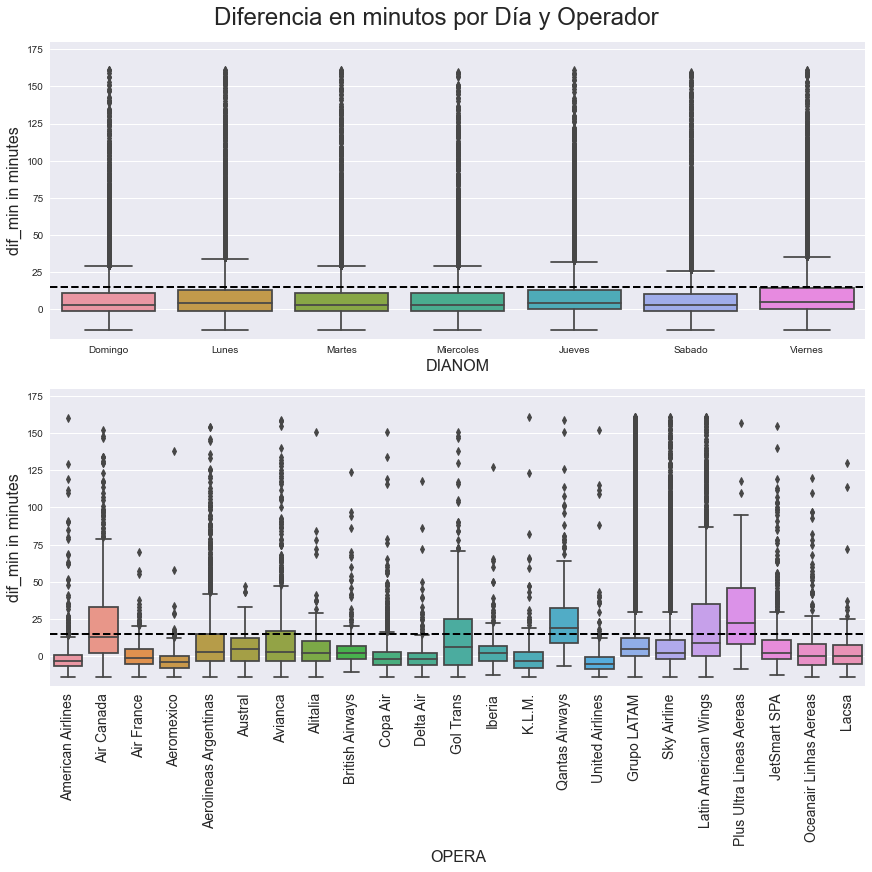

In [15]:
fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(12,12))

# dif_min boxplot by DIANOM,
sns.boxplot(data=data_SCL, x="DIANOM", y="dif_min", ax=axs[0])
axs[0].set_xlabel("DIANOM", size=16)
axs[0].set_ylabel("dif_min in minutes", size=16)
axs[0].set_ylim(-20, 180)
axs[0].axhline(y=15, linestyle="--", linewidth="2", color="black")

# dif_min boxplot by OPERA
sns.boxplot(data=data_SCL, x="OPERA", y="dif_min", ax=axs[1])
axs[1].set_xlabel("OPERA", size=16)
axs[1].set_ylabel("dif_min in minutes", size=16)
axs[1].set_ylim(-20, 180)
axs[1].axhline(y=15, linestyle="--", linewidth="2", color="black")
plt.xticks(rotation=90, size=14)

fig.suptitle("Diferencia en minutos por Día y Operador", size=24)
plt.savefig("graphs/BXPLT_dif_min02.png", bbox_inches="tight")

El boxplot de diferencia de minutos por día, tampoco revela diferencias significativas que ayuden a esclarecer los factores que inciden en el atraso mayor a quince minutos de un vuelo; sin embargo, el boxplot que revela las diferencias por Operador, permite por primera vez, apreciar diferencias que se aprecian significativas respecto de la diferencia en minutos.

El boxplot que separa los vuelos por Operador, permite ver que:
* Exiten aerolíneas cuya media (línea del medio de la caja), está por sobre la marca de los quince minutos, tales como Quantas Airways o Plus Ultra Líneas.
* Existen aerolíneas que se mantienen al menos hasta el percentil 75, bajo la marca de quince minutos, tales como Iberia, KLM, Jet Smart SPA, Lacsa.
* Existen aerolíneas que están en condición borde, con la media apenas por debajo de la marca de quince minutos, pero con una fracción relativamente significativa de vuelos por sobre el límite  de quince minutos, tales como Air Canada, Gol Trans, Latin American Wings.
* Finalmente existen aerolíneas que solamente sus valores outliers, quedan por sobre la marca de quince minutos de diferencia, tales como American Airlines, Aeroméxico, Delta Air, United Airlines.

De esto se puede inferir que la variable **OPERA** pudiera ser considerado un factor predictor de atraso.

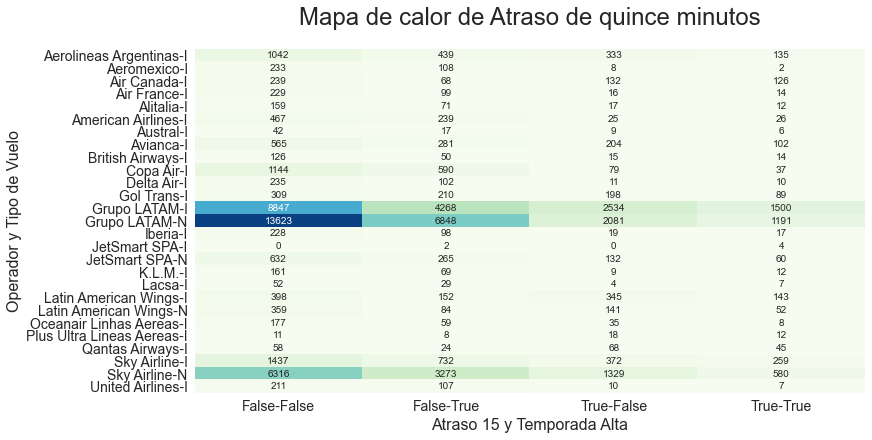

In [16]:
# HEATMAP
c_tab = pd.crosstab([data_SCL.OPERA, data_SCL.TIPOVUELO],
                    [data_SCL.atraso_15, data_SCL.temporada_alta])

fig, ax = plt.subplots(constrained_layout=True, figsize=(12, 6))

sns.heatmap(c_tab, annot=True, cbar=False, fmt="g", cmap="GnBu", ax=ax)
ax.set_xlabel("Atraso 15 y Temporada Alta", size=16)
ax.set_ylabel("Operador y Tipo de Vuelo", size=16)
ax.set_title("Mapa de calor de Atraso de quince minutos", size=24, pad=24)
ax.tick_params(axis="both", which="major", labelsize=14)

plt.savefig("graphs/CRSSTB01.png", bbox_inches="tight")

El mapa de calor que se presenta, expresa la cuantificación de vuelos entre aerolíneas, tipos de vuelo, atraso_15 (variable sintética que califica diferencia de minutos respecto de la marca de quince), y temporada alta (variable sintética que agrupa determinadas semanas de mayor demanda).

Lo primero que se puede apreciar, es que los colores más intensos, están concentrados en Grupo Latam, tanto nacional como internacional. Los colores azul oscuro y celeste indican mayor cantidad de vuelos sin atraso en temporada regular (false-false), y le siguen luego, los vuelos sin atraso en temporada alta(false-true).

El siguiente operador con más vuelos viene a ser Sky Airline Nacional, también con la mayor representación en no atraso y temporada baja (false-false); finalmente, en menor medida, nuevamente está Sky Airline Internacional.

Esta información es relevante, puedes se puede observar que unos pocos Operadores, podrían concentrar sobre el 80% de los vuelos.

## Machine Learning

A tener en consideración, estaré utilizando como medidas evaluación de los modelos: 
* ***recall score*** como medida principal, pues el enfoque que estoy tomando, es que el interés está en determinar que tan acertada es la predicción de la clase verdadera (atraso_15/True) que es además, la clase minoritaria (aprox 20% de los datos) 
* ***accuracy*** como medida secundaria de la clasificación, en caso que sea requerido para discernir en entre dos modelos con el mismo *recall score*.

In [28]:
"""La preparación de los datos será unica para todos los modelos
que serán evaluados"""
# DATA PREP
# Listing non-relevant variables
to_drop =["Fecha-I", "Vlo-I", "Ori-I", "Des-I", "Emp-I", "Fecha-O",
          "Vlo-O", "Ori-O", "Emp-O", "DIA", "AÑO", "DIANOM", "dif_min", "atraso_15"]

X = data_SCL.drop(labels=to_drop, axis=1)
X = X.astype("object")

y = data_SCL.atraso_15

# Encoding variables to enable the use of categorial NB
enc = OrdinalEncoder()
enc.fit(X)
Xenc = enc.transform(X)

# Data splitting
"""Estoy aplicando estratificación sobre la variable dependiente para asegurar que tanto
en el set entrenamiento como en el de testeo se mantenga la relación 80/20"""
X_train, X_test, y_train, y_test = train_test_split(Xenc, y, test_size=0.30,
                                                random_state=13,
                                                stratify=y)

### Categorical Naive Bayes

El recall score del mejor modelo CNB es 19.93%
El accuracy score del mejor modelo CNB es 79.01%
El valor de alpha del mejor modelo CNB es 0.1


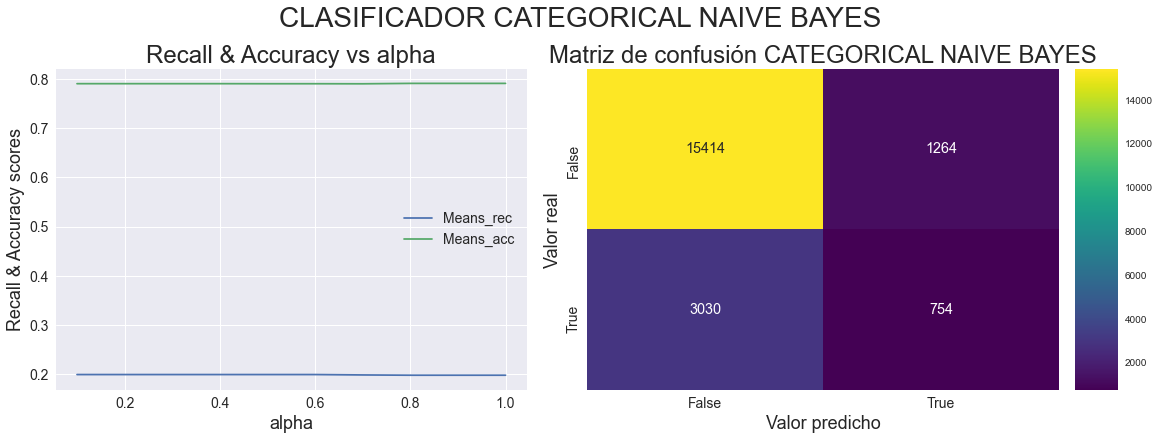

In [99]:
# MODELING & SCORING
"""Normalmente hubiera aplicado Cross Validation, pero al intentarlo
obtuve mensajes de error, ya que no siempre se encontraban las mismas
etiquetas para todos elementos tanto en los conjuntos de prueba y entrenamiento"""

# Hiperparameter tuning: alpha
means_rec = []
means_acc = []
alphas = np.arange(0.1, 1.1, 0.1)

for i in range(alphas.shape[0]):
    CNB = CategoricalNB(alpha=alphas[i])
    CNB.fit(X_train, y_train)
    y_pred = CNB.predict(X_test)
    means_rec.append(recall_score(y_test, y_pred))
    means_acc.append(CNB.score(X_test, y_test))

means_rec  =  np.array(means_rec)
means_acc  =  np.array(means_acc)

best_alpha = np.where(means_rec == np.amax(means_rec))
alpha = alphas[best_alpha[0][0]]

# Running again to plot overall and best results
CNB = CategoricalNB(alpha=alpha)
CNB.fit(X_train, y_train)
y_pred = CNB.predict(X_test)
cm = pd.crosstab(y_test, y_pred)
CNB_rec = round(recall_score(y_test, y_pred)*100, 2)
CNB_acc = round(CNB.score(X_test, y_test)*100, 2)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(16,6))

sns.lineplot(x=alphas, y=means_rec, ax=axs[0])
sns.lineplot(x=alphas, y=means_acc, ax=axs[0])
axs[0].set_xlabel('alpha', size=18)
axs[0].set_ylabel('Recall & Accuracy scores', size=18)
axs[0].set_title('Recall & Accuracy vs alpha', size=24)
axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[0].legend(["Means_rec", "Means_acc"], loc=7, fontsize=14)

sns.heatmap(data=cm, annot=True, fmt="g", cmap="viridis",
            annot_kws={"fontsize":"x-large"}, ax=axs[1])
axs[1].set_xlabel("Valor predicho", size=18)
axs[1].set_ylabel("Valor real", size=18)
axs[1].set_title('Matriz de confusión CATEGORICAL NAIVE BAYES', size=24)
axs[1].tick_params(axis='both', which='major', labelsize=14)

plt.suptitle('CLASIFICADOR CATEGORICAL NAIVE BAYES', size = 28)
plt.savefig("graphs/CNB_lineplot_heatmap01.png", bbox_inches="tight")

print(f"El recall score del mejor modelo CNB es {CNB_rec}%")
print(f"El accuracy score del mejor modelo CNB es {CNB_acc}%")
print(f"El valor de alpha del mejor modelo CNB es {alpha}")


El resultado del clasificador Categorical NB, se percibe bastante subpar, puesto que aunque llega a desarrollar una ***accuracy*** cercana al 80%, se debe principalmente a que está clasificando en forma correcta los vuelos VN (aquellos con valor 0 en la variable *atraso_15*). El ***recall_score*** de 20% evidencia el bajo desempeño en clasificar adecuadamente los valores 1 de atraso_15.

### Decision Tree Classifier

El recall score del mejor modelo DTC es 11.92%
El accuracy score del mejor modelo DTC es 81.85%
El valor de max_features del mejor modelo DTC es 1


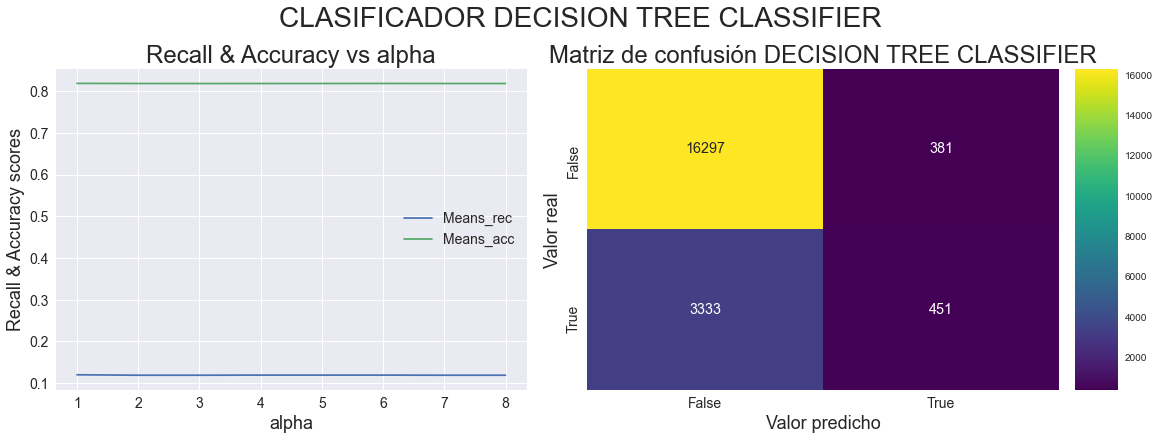

In [111]:
# MODELING & SCORING
# Hiperparameter tuning: max_features
means_rec = []
means_acc = []
features = np.arange(1, 9, 1)

for i in range(features.shape[0]):
    DTC = DecisionTreeClassifier(max_features=features[i])
    DTC.fit(X_train, y_train)
    y_pred = DTC.predict(X_test)
    means_rec.append(recall_score(y_test, y_pred))
    means_acc.append(DTC.score(X_test, y_test))

means_rec  =  np.array(means_rec)
means_acc  =  np.array(means_acc)

best_feature = np.where(means_rec == np.amax(means_rec))
max_feature = features[best_feature[0][0]]

# Running again to plot overall and best results
DTC = DecisionTreeClassifier(max_features=max_feature)
DTC.fit(X_train, y_train)
y_pred = DTC.predict(X_test)
cm = pd.crosstab(y_test, y_pred)
DTC_rec = round(recall_score(y_test, y_pred)*100, 2)
DTC_acc = round(DTC.score(X_test, y_test)*100, 2)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(16,6))

sns.lineplot(x=features, y=means_rec, ax=axs[0])
sns.lineplot(x=features, y=means_acc, ax=axs[0])
axs[0].set_xlabel('alpha', size=18)
axs[0].set_ylabel('Recall & Accuracy scores', size=18)
axs[0].set_title('Recall & Accuracy vs alpha', size=24)
axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[0].legend(["Means_rec", "Means_acc"], loc=7, fontsize=14)

sns.heatmap(data=cm, annot=True, fmt="g", cmap="viridis",
            annot_kws={"fontsize":"x-large"}, ax=axs[1])
axs[1].set_xlabel("Valor predicho", size=18)
axs[1].set_ylabel("Valor real", size=18)
axs[1].set_title('Matriz de confusión DECISION TREE CLASSIFIER', size=24)
axs[1].tick_params(axis='both', which='major', labelsize=14)

plt.suptitle('CLASIFICADOR DECISION TREE CLASSIFIER', size = 28)
plt.savefig("graphs/DTC_lineplot_heatmap01.png", bbox_inches="tight")

print(f"El recall score del mejor modelo DTC es {DTC_rec}%")
print(f"El accuracy score del mejor modelo DTC es {DTC_acc}%")
print(f"El valor de max_features del mejor modelo DTC es {max_feature}")

El Decision Tree Classifier presenta un valor de ***accuracy*** ligeramente más alto que el Categorical Naive Bayes, sin embargo, la baja de casi 10% en el ***recall_score*** es indicativo que el modelo es mejor en clasificar los valores verdadero-negativos, pero mucho peor en cuanto a identificar los verdadero-positivos, que son el motivo de estudio de este challenge.

### Random Forest Classifier

El recall score del mejor modelo RFC es 13.19%
El accuracy score del mejor modelo RFC es 81.66%
El valor de n_estimators del mejor modelo RFC es 250


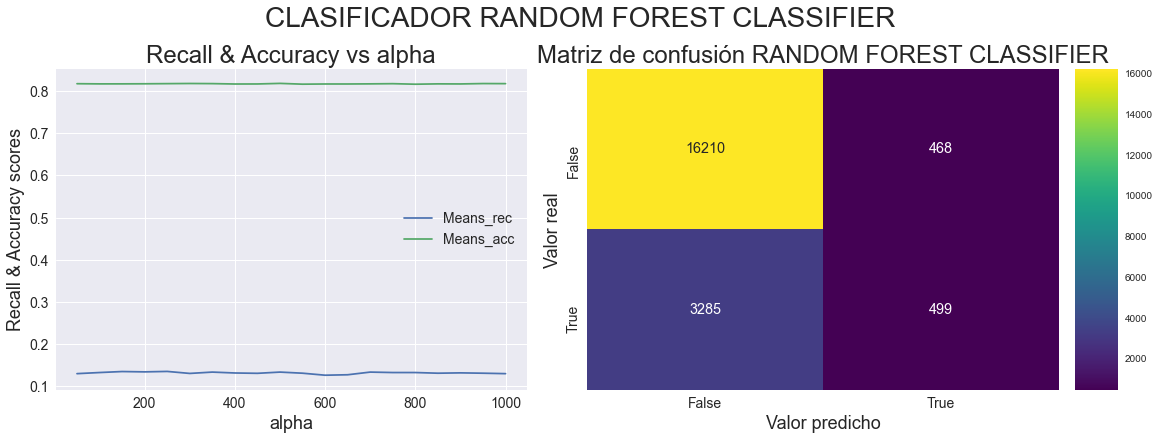

In [116]:
# MODELING & SCORING
# Hiperparameter tuning: n_estimators
means_rec = []
means_acc = []
estimators = np.arange(50, 1001, 50)

for i in range(estimators.shape[0]):
    RFC = RandomForestClassifier(n_estimators=estimators[i])
    RFC.fit(X_train, y_train)
    y_pred = RFC.predict(X_test)
    means_rec.append(recall_score(y_test, y_pred))
    means_acc.append(RFC.score(X_test, y_test))

means_rec  =  np.array(means_rec)
means_acc  =  np.array(means_acc)

best_estimator = np.where(means_rec == np.amax(means_rec))
nestimator = estimators[best_estimator[0][0]]

# Running again to plot overall and best results
RFC = RandomForestClassifier(n_estimators=nestimator)
RFC.fit(X_train, y_train)
y_pred = RFC.predict(X_test)
cm = pd.crosstab(y_test, y_pred)
RFC_rec = round(recall_score(y_test, y_pred)*100, 2)
RFC_acc = round(RFC.score(X_test, y_test)*100, 2)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(16,6))

sns.lineplot(x=estimators, y=means_rec, ax=axs[0])
sns.lineplot(x=estimators, y=means_acc, ax=axs[0])
axs[0].set_xlabel('alpha', size=18)
axs[0].set_ylabel('Recall & Accuracy scores', size=18)
axs[0].set_title('Recall & Accuracy vs alpha', size=24)
axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[0].legend(["Means_rec", "Means_acc"], loc=7, fontsize=14)

sns.heatmap(data=cm, annot=True, fmt="g", cmap="viridis",
            annot_kws={"fontsize":"x-large"}, ax=axs[1])
axs[1].set_xlabel("Valor predicho", size=18)
axs[1].set_ylabel("Valor real", size=18)
axs[1].set_title('Matriz de confusión RANDOM FOREST CLASSIFIER', size=24)
axs[1].tick_params(axis='both', which='major', labelsize=14)

plt.suptitle('CLASIFICADOR RANDOM FOREST CLASSIFIER', size = 28)
plt.savefig("graphs/RFC_lineplot_heatmap01.png", bbox_inches="tight")

print(f"El recall score del mejor modelo RFC es {RFC_rec}%")
print(f"El accuracy score del mejor modelo RFC es {RFC_acc}%")
print(f"El valor de n_estimators del mejor modelo RFC es {nestimator}")

Similar al caso del Decision Tree Classifier, el Random Forest Classifier sacrifica clasifación de verdaderos-positivos (baja de ***recall_score*** a 13%) para un desemepeño ligeramente superior de ***accuracy*** de 81%.

### Support Vector Machine Classifier

C:\Users\pablo\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\pablo\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\pablo\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\pablo\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\pablo\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iteration

El recall score del mejor modelo LSVC es 0.0%
El accuracy score del mejor modelo LSVC es 81.51%
El valor de n_estimators del mejor modelo LSVC es 3700


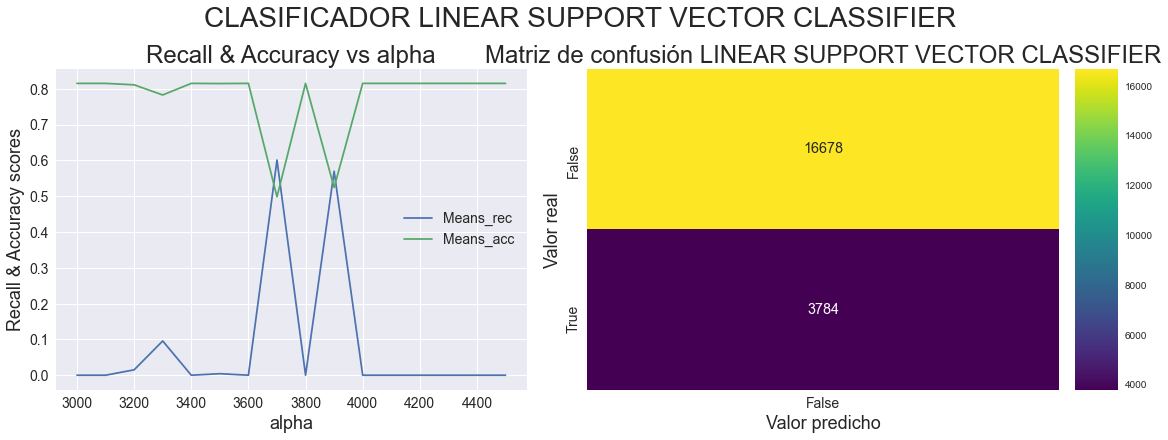

In [128]:
# MODELING & SCORING
# Hiperparameter tuning: max_iter
means_rec = []
means_acc = []
iterations = np.arange(3000, 4501, 100)

for i in range(iterations.shape[0]):
    LSVC = LinearSVC(max_iter=iterations[i])
    LSVC.fit(X_train, y_train)
    y_pred = LSVC.predict(X_test)
    means_rec.append(recall_score(y_test, y_pred))
    means_acc.append(LSVC.score(X_test, y_test))

means_rec  =  np.array(means_rec)
means_acc  =  np.array(means_acc)

best_iteration = np.where(means_rec == np.amax(means_rec))
iteration = iterations[best_iteration[0][0]]

# Running again to plot overall and best results
LSVC = LinearSVC(max_iter=iteration)
LSVC.fit(X_train, y_train)
y_pred = LSVC.predict(X_test)
cm = pd.crosstab(y_test, y_pred)
LSVC_rec = round(recall_score(y_test, y_pred)*100, 2)
LSVC_acc = round(LSVC.score(X_test, y_test)*100, 2)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(16,6))

sns.lineplot(x=iterations, y=means_rec, ax=axs[0])
sns.lineplot(x=iterations, y=means_acc, ax=axs[0])
axs[0].set_xlabel('alpha', size=18)
axs[0].set_ylabel('Recall & Accuracy scores', size=18)
axs[0].set_title('Recall & Accuracy vs alpha', size=24)
axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[0].legend(["Means_rec", "Means_acc"], loc=7, fontsize=14)

sns.heatmap(data=cm, annot=True, fmt="g", cmap="viridis",
            annot_kws={"fontsize":"x-large"}, ax=axs[1])
axs[1].set_xlabel("Valor predicho", size=18)
axs[1].set_ylabel("Valor real", size=18)
axs[1].set_title('Matriz de confusión LINEAR SUPPORT VECTOR CLASSIFIER', size=24)
axs[1].tick_params(axis='both', which='major', labelsize=14)

plt.suptitle('CLASIFICADOR LINEAR SUPPORT VECTOR CLASSIFIER', size = 28)
plt.savefig("graphs/LSVC_lineplot_heatmap01.png", bbox_inches="tight")

print(f"El recall score del mejor modelo LSVC es {LSVC_rec}%")
print(f"El accuracy score del mejor modelo LSVC es {LSVC_acc}%")
print(f"El valor de n_estimators del mejor modelo LSVC es {iteration}")

El Linear Support Vector Classifier falló en converger después de varios intentos con distintos tramos de iteraciones, por lo que sus resultados no son de fiar al aplicar la formulación de los modelos anteriores (encontrar el mejor valor del parámetro buscado y volver a correr el modelo para hacer la matriz de confusión). A pesar de ello, entre sus resultados, se observaron algunas instancias en las que el ***recall_score*** subió por sobre el 50%, aunque conllevó una baja igualmente significativa en la ***accuracy***, valores del 50%.

#### Pendientes
Pendientes de realizar, en este Notebook o en futuras iteraciones:
* En sección VDA, respecto de los boxplots, hacer comparaciones de las mismas variables (tipo vuelo, temporada, operador, día de la semana, etc), contra la variable atraso_15. En primera instancia me pareció razonable tomar como referencia la diferencia de minutos como medida de observación; sin embargo, durante el desarrollo del NB, he pensado que quizá un enfoque más práctico y reducido, pudiera rendir mejores resultados. Esto porque finalmente, en la sección de ML, estaré aplicando clasificadores y no regresores, es decir, vale si es atraso o no atraso, y no la cuantificación del mismo.
* Generar pipeline para correr todos los modelos de clasificación.
* Utilizar forward y back propagation para determinar las variables que más aportan en la clasificación. Es posible que el criterio utilizado para determinar las variables explicativas sea causal de los bajos valores de ***recall_score*** obtenidos.
* Generar matrices de hiperparametrización para buscar mejores combinaciones de parámetros de los modelos utilizados.
* Generar modelos más complejos con ensembles.